In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from toolz.curried import get, curry, compose

# Define environment

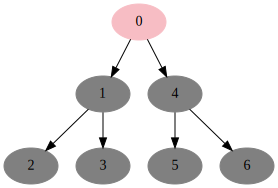

In [2]:
from distributions import Normal
import distributions
from mouselab import MouselabEnv
from exact import solve

def make_env():
    reward = Normal(3, 6).to_discrete(6).apply(compose(int, round))
    return MouselabEnv.new_symmetric([2,2], reward, cost=1)

env = make_env()
env.render()

# Optimal policy

Because we can compute the true optimal Q function, we can implement the optimal policy
as a `SoftmaxPolicy` using `Q` as a preference function, and a very low temperature.

In [3]:
from policies import SoftmaxPolicy
Q, V, *_ = solve(env)
V(env.init)
optimal_policy = SoftmaxPolicy(Q)

## Simulate rollouts

Running rollouts of the optimal policy on 200 randomly selected environments.

In [4]:
from agents import run_episode

def simulate(policy, envs, seed=None, repeat=1):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    for env_id, env in envs.items():
        for _ in range(repeat):
            trace = run_episode(policy, env)
            for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
                yield {'seed': seed, 'cost': abs(env.cost), 'env_id': env_id,
                       'state': s, 'action': a, 'reward': r}

envs = Series([make_env() for _ in range(200)])
df_optimal = DataFrame(simulate(optimal_policy, envs))

## View rollouts

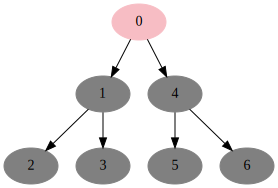

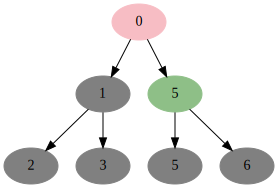

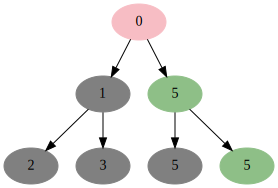

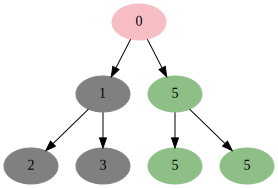

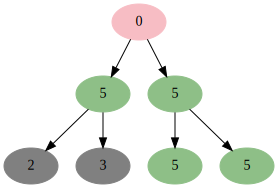

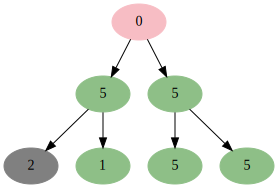

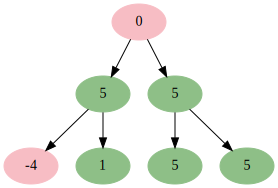

In [5]:
from IPython.display import display
def render(trace):
    for i, (s, a, r) in enumerate(zip(*get(['states', 'actions', 'rewards'], trace))):
        env._state = s
        dot = env.render()
        display(dot)

from agents import run_episode
trace = run_episode(optimal_policy, env)
render(trace)

## Model

`SoftMaxPolicy` selects actions by sampling from action probabilities generated by its
`action_distribution` method. We can use that method as a likelihood model as well.
I print summary statistics to get an idea of the fit quality. "Predictive power" (a name I made up)
is very similar to _perplexity_, but it's in probability units.

In [6]:
def policy_model(policy, data):
    return data.apply(lambda row: policy.action_distribution(row.state)[row.action], axis=1)

logp_optimal = np.log(policy_model(optimal_policy, df_optimal))
print('Probabilities of optimal policy actions under the optimal model')
print(np.exp(logp_optimal).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_optimal.mean()):.3f}', )

Probabilities of optimal policy actions under the optimal model
0.333333      2
0.333333     15
0.333334      8
0.500000      3
0.500000    456
1.000000    403
dtype: int64

Predictive power: 0.677


# Random Policy

Now we can do the same thing again (without redefining functions) for the random policy.
Note that the random policy is uniform oveer *legal* actions only. As we would hope, it
less predictive of itself compared to the optimal policy.

In [7]:
from mouselab_policy import MouselabPolicy
rand_policy = MouselabPolicy({'term_reward': 0})
# NOTE: must run one episode before calling for action_distribution
run_episode(rand_policy, env)
env.reset()
env.step(2)
print(env._state)
print(rand_policy.action_distribution(env._state))

(0, Cat, -4, Cat, Cat, Cat, Cat)
[0.    0.167 0.    0.167 0.167 0.167 0.167 0.167]


In [8]:
df = DataFrame(simulate(rand_policy, envs))
logp_rand = np.log(policy_model(rand_policy, df))
print('Probabilities of random policy actions under the random model')
print(np.exp(logp_rand).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_rand.mean()):.3f}', )

Probabilities of random policy actions under the random model
0.142857    200
0.166667    172
0.200000    141
0.250000    102
0.333333     78
0.500000     47
1.000000     30
dtype: int64

Predictive power: 0.215


# Best first

This is just a start, not sure it's correct.

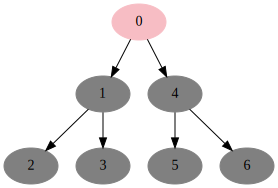

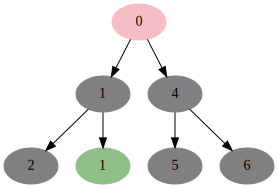

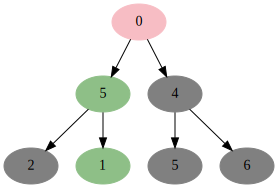

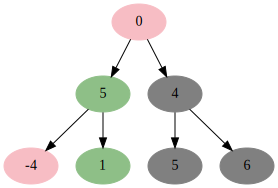

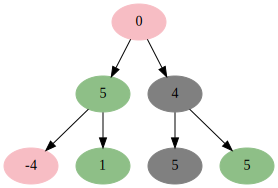

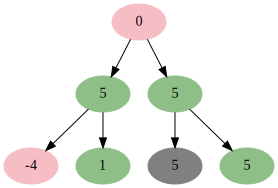

In [9]:
def best_first_pref(state, action, satisfice=9, prune_t=-4):
    if action == env.term_action:
        if env.expected_term_reward(state) > satisfice:
            return 1e10  # always terminate
        else:
            return -1e10  # never terminate (unless it's the only option)
    q = env.node_quality(action, state)  # note backwards arguments!  plz don't ask why...
    return q.expectation()  # node_quality is a distribution, we just want the mean

best_first_policy = SoftmaxPolicy(best_first_pref)
bf_trace = run_episode(best_first_policy, env)
render(bf_trace)

In [10]:
df = DataFrame(simulate(best_first_policy, envs))
logp_best_first = np.log(policy_model(best_first_policy, df))
print('Probabilities of best_firstom policy actions under the best_firstom model')
print(np.exp(logp_best_first).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_best_first.mean()):.3f}', )

Probabilities of best_firstom policy actions under the best_firstom model
0.166667    200
0.200000     74
0.250000     11
0.333333     76
0.500000    100
1.000000    344
dtype: int64

Predictive power: 0.448


## Breadth First

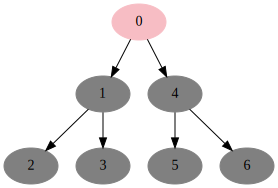

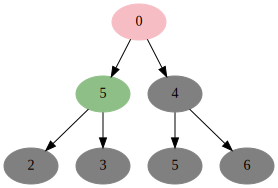

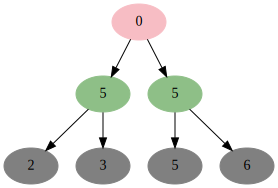

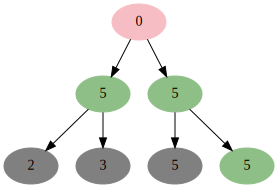

In [12]:
def breadth_first_pref(state, action, satisfice=9):
    if action == env.term_action: #not too sure about this, ask Fred
        if env.expected_term_reward(state) > satisfice:
            return 1e10  # always terminate
        else:
            return -1e10  # never terminate (unless it's the only option)
    num_lvls = len(env.all_paths()[0]) - 1
    levels = [set() for i in np.arange(num_lvls)]
    for path in env.all_paths(): #figure out a more efficient way later
        path = path[1:]
        for k in np.arange(num_lvls):
            levels[k].add(path[k])
    #check which level action is on
    for j in np.arange(num_lvls):
        if action in levels[j]:
            return 1
        else:
            #check to see whether all the nodes in that level have been observed
            for node in levels[j]:
                if hasattr(env._state[node], 'sample'):
                    return 0  

breadth_first_policy = SoftmaxPolicy(breadth_first_pref)
bdf_trace = run_episode(breadth_first_policy, env)
render(bdf_trace)

In [13]:
df = DataFrame(simulate(breadth_first_policy, envs))
logp_breadth_first = np.log(policy_model(breadth_first_policy, df))
print('Probabilities of breadth_first policy actions under the breadth_first model')
print(np.exp(logp_breadth_first).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_breadth_first.mean()):.3f}', )

Probabilities of breadth_first policy actions under the breadth_first model
0.166667    200
0.200000    154
0.250000    119
0.333333     90
0.500000     64
1.000000    246
dtype: int64

Predictive power: 0.351


## Depth First

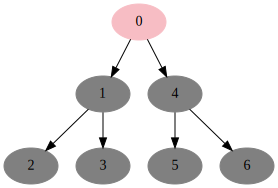

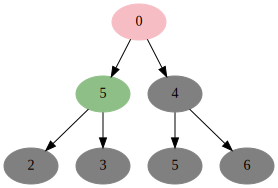

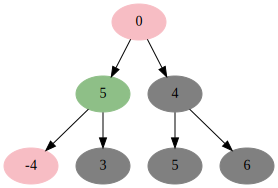

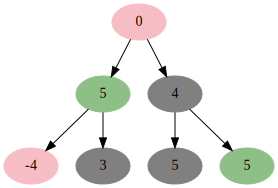

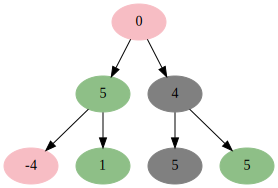

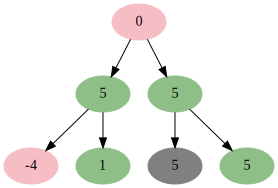

In [29]:
def depth_first_pref(state, action, satisfice=9):
#     if action == env.term_action:
#         if env.expected_term_reward(state) > satisfice:
#             return 1e10  # always terminate
#         else:
#             return -1e10  # never terminate (unless it's the only option)
    num_nodes = len(env.subtree[0])
    if env._state == env.init:
        sub_length = len(env.subtree[1])
        possible_actions = []
        for tree in env.subtree:
            if len(tree) == sub_length:
                possible_actions.append(tree[0])
        if action in possible_actions:
            return 1
        else:
            return 0
    """General idea: Keep track of how many nodes have been explored on each path.
    If there is a path that has been explored deeper compared to the path action is on, return 0. Otherwise, 1."""
    max_depth = len(env.all_paths()[0]) - 1
    action_path_depth = 0
    cur_max = 0
    for og_path in env.all_paths():
        count = 0 #how many nodes have been clicked sequentially on that path
        path = og_path[1:] #get rid of the initial 0
        for i in np.arange(len(path)):
            if path[i] == action:
                if count > action_path_depth:
                    action_path_depth = count
                break #we don't care about nodes after the proposed action
            if (hasattr(env._state[path[i]], 'sample')) and (count < max_depth-1): #second check is to make sure leaves don't get passed over
                count = 0
            else:
                count += 1
        if (count != max_depth) and (count > cur_max): #avoid subtrees that have been searched to completion
            cur_max = count
    if action_path_depth >= cur_max:
        return 1
    else:
        return 0  

depth_first_policy = SoftmaxPolicy(depth_first_pref)
df_trace = run_episode(depth_first_policy, env)
render(df_trace)

In [63]:
num= 3
[set() for i in np.arange(num)]

[set(), set(), set()]

In [112]:
env._state == env.init

True

In [66]:
hasattr(env._state[2], 'sample')

False

In [65]:
type(env._state[4]) 

numpy.int32

In [14]:
env.leaves() #use for backwards best

[2, 3, 5, 6]

In [17]:
env.subtree 

[(0, 1, 2, 3, 4, 5, 6), (1, 2, 3), (2,), (3,), (4, 5, 6), (5,), (6,)]

In [110]:
sub_length = len(env.subtree[1])
possible_actions = []
for tree in env.subtree:
    if len(tree) == sub_length:
        possible_actions.append(tree[0])

In [111]:
possible_actions

[1, 5, 9]

In [97]:
env.step(4)
env.unclicked(env._state)

11

In [18]:
env.all_paths()

[[0, 1, 2], [0, 1, 3], [0, 4, 5], [0, 4, 6]]

In [125]:
np.arange(3)

array([0, 1, 2])

In [78]:
env.term_action

13